In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from osgeo import gdal
import rasterio
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
import scipy.stats as stats

ModuleNotFoundError: No module named 'geopandas'

In [2]:
RedV1 = gpd.read_file(r'D:\PhD\TickBase\Yan\Simulated_GPS\Ramah_RedV1.shp')
RedV2 = gpd.read_file(r'D:\PhD\TickBase\Yan\Simulated_GPS\Ramah_RedV2.shp')
Cove = gpd.read_file(r'D:\PhD\TickBase\Yan\Simulated_GPS\Ramah_Cove.shp')
BlackMesa = gpd.read_file(r'D:\PhD\TickBase\Yan\Simulated_GPS\Ramah_BlackMesa.shp')

In [3]:
# Sentinel-2 10m LULC Time Series data
# https://www.arcgis.com/home/item.html?id=d3da5dd386d140cf93fc9ecbf8da5e31
# https://livingatlas.arcgis.com/landcoverexplorer/#mapCenter=-3.286%2C31.34%2C3&mode=step&timeExtent=2017%2C2021&year=2022&downloadMode=true
# 2022
Senti_file_AZ = rasterio.open(r'D:\PhD\TickBase\Yan\Envi_Data\LandCover\Senti_Esri\AZ\12S_20220101-20230101.tif')
Senti_file_NM = rasterio.open(r'D:\PhD\TickBase\Yan\Envi_Data\LandCover\Senti_Esri\NM\13S_20220101-20230101.tif')

In [4]:
time_period = 14 # "2 weeks"
start_time = 1 # 1 day after the origin point 
end_time = 1 # 1 day before the last point

In [5]:
coords = [(x,y) for x,y in zip(RedV2.geometry.x,RedV2.geometry.y)]
RedV2['LULC'] = [x[0] for x in Senti_file_AZ.sample(coords)]
#RedV2.loc[RedV2['RasterV']!=0]

In [14]:
df_shape = RedV2.shape
RedV2['time'] = pd.to_datetime(RedV2['time'], format = '%m/%d/%Y %H:%M')
LULC_set = np.unique(RedV2['LULC'])

period_start_time = RedV2.loc[0,'time']
period_end_time = RedV2.loc[df_shape[0]-1,'time']

n_period = (period_end_time - period_start_time).total_seconds()/3600/24/time_period

<font color = 'Blue'> <b>Tick counts simulation</b>
<br>
</font>

In [12]:
mean = 100
std = 25
T_cts = np.random.normal(mean, std, int(n_period)+1)
T_cts

array([ 99.74145565,  94.34819185,  94.73177219, 108.07979809,
        92.08625945])

<font color = 'Blue'> <b>Class Data (no numeric)</b>
<br>
</font>

Text(0.5, 1.0, 'Time (min)')

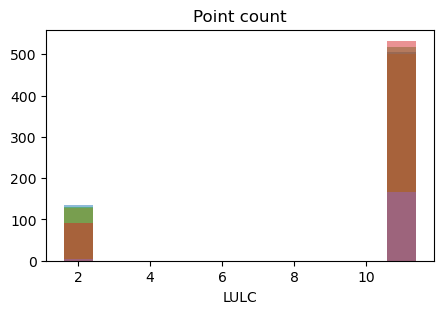

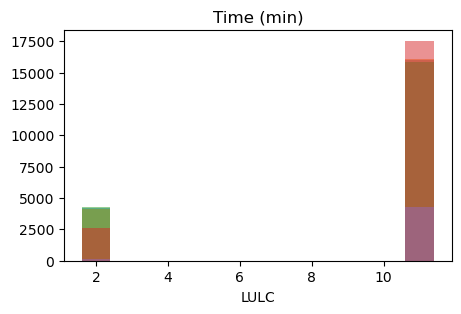

In [6]:
count_set = pd.DataFrame(0,columns = np.unique(RedV2['LULC']), index = range(int(n_period+1)))
n = 0
for i in RedV2.index:
    if i == RedV2.shape[0] - 1:
        break
    if RedV2.loc[i,'time'] >= period_start_time + timedelta(days=n*time_period) and RedV2.loc[i,'time'] <= period_start_time + timedelta(days=(n+1)*time_period):
        for j in LULC_set:
            if RedV2.loc[i,'LULC'] == j:
                count_set.loc[n,j] = count_set.loc[n,j] + 1
                break
    else:
        n = n + 1
    
#count_set = np.array(count_set)

time_set = pd.DataFrame(0,columns = np.unique(RedV2['LULC']), index = range(int(n_period+1)))
n = 0
for i in RedV2.index:
    if i == RedV2.shape[0] - 1:
        break
    if RedV2.loc[i,'time'] >= period_start_time + timedelta(days=n*time_period) and RedV2.loc[i,'time'] <= period_start_time + timedelta(days=(n+1)*time_period):
        for j in LULC_set:
            if RedV2.loc[i,'LULC'] == j:
                time_set.loc[n,j] = time_set.loc[n,j] + (RedV2.loc[i+1,'time']-RedV2.loc[i,'time']).total_seconds()/60.0
                break
    else:
        n = n + 1

fig, ax = plt.subplots(figsize = (5,3))
for n in range(int(n_period)+1):
    plt.bar(np.unique(RedV2['LULC']),count_set.iloc[n],alpha = 0.5)
plt.xlabel('LULC')
ax.set_title('Point count')

fig1, ax1 = plt.subplots(figsize = (5,3))
for n in range(int(n_period)+1):
    plt.bar(np.unique(RedV2['LULC']),time_set.iloc[n],alpha = 0.5)
plt.xlabel('LULC')
ax1.set_title('Time (min)')

<font color = 'Blue'> <b>Numeric Data</b>
<br>
</font>

In [7]:
RedV2.head()

,GMT Time,Latitude,Longitude,Altitude,Duration,Temperatur,Voltage,DOP,Satellites,Cause of F,Lab_Coord,Lab_Dur,Lab_Sat,Lab_Alt,No,time,distance,speed,geometry,LULC
0,8/10/2021 14:31,34.790283,-108.305657,2690.83,65,19.0,0,3.0,5,GPS Schedule,0.0,0.0,0.0,0.0,1,2021-08-10 08:31:00,-1.000000,-1.000000,POINT (746520.733 3853095.300),11
1,8/10/2021 14:45,34.795679,-108.303513,2690.13,3,18.0,0,3.6,5,GPS Schedule,0.0,0.0,0.0,0.0,2,2021-08-10 08:45:00,45.880294,3.276863,POINT (746700.929 3853699.248),2
2,8/10/2021 15:00,34.792382,-108.297636,2685.92,3,18.5,0,3.8,5,GPS Schedule,0.0,0.0,0.0,0.0,3,2021-08-10 09:00:00,85.194239,2.353872,POINT (747248.551 3853347.996),11
3,8/10/2021 15:15,34.794316,-108.304693,2677.39,3,18.5,0,3.2,5,GPS Schedule,0.0,0.0,0.0,0.0,4,2021-08-10 09:15:00,8.960635,0.463648,POINT (746596.977 3853545.118),11
4,8/10/2021 15:30,34.799378,-108.307767,2651.16,2,18.5,0,2.6,5,GPS Schedule,0.0,0.0,0.0,0.0,5,2021-08-10 09:30:00,9.585296,0.702347,POINT (746300.609 3854099.176),11


c:\ProgramData\Anaconda3\envs\geopandas_docs\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Text(0.5, 1.0, 'Z Normalized: Cumulative index * Time')

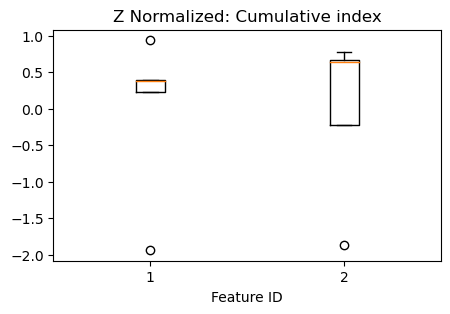

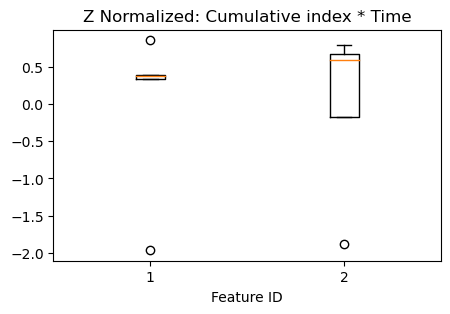

In [33]:
##################################################
features = ['speed', 'Temperatur']
##################################################
Cumu_index = pd.DataFrame(0,columns = features, index = range(int(n_period+1)))
n = 0
for i in RedV2.index:
    if i == RedV2.shape[0] - 1:
        break
    if RedV2.loc[i,'time'] >= period_start_time + timedelta(days=n*time_period) and RedV2.loc[i,'time'] <= period_start_time + timedelta(days=(n+1)*time_period):
        Cumu_index.loc[n,'speed'] = Cumu_index.loc[n,'speed'] + RedV2.loc[i,'speed']
        Cumu_index.loc[n,'Temperatur'] = Cumu_index.loc[n,'Temperatur'] + RedV2.loc[i,'Temperatur']
    else:
        n = n + 1
    
#count_set = np.array(count_set)

Cumu_index_time = pd.DataFrame(0,columns = features, index = range(int(n_period+1)))
n = 0
for i in RedV2.index:
    if i == RedV2.shape[0] - 1:
        break
    if RedV2.loc[i,'time'] >= period_start_time + timedelta(days=n*time_period) and RedV2.loc[i,'time'] <= period_start_time + timedelta(days=(n+1)*time_period):
        Cumu_index_time.loc[n,'speed'] = Cumu_index_time.loc[n,'speed'] + RedV2.loc[i,'speed'] * (RedV2.loc[i+1,'time']-RedV2.loc[i,'time']).total_seconds()/60.0
        Cumu_index_time.loc[n,'Temperatur'] = Cumu_index_time.loc[n,'Temperatur'] + RedV2.loc[i,'Temperatur'] * (RedV2.loc[i+1,'time']-RedV2.loc[i,'time']).total_seconds()/60.0
    else:
        n = n + 1

Cumu_index_norm = (Cumu_index - np.mean(Cumu_index))/np.std(Cumu_index)
Cumu_index_time_norm = (Cumu_index_time - np.mean(Cumu_index_time))/np.std(Cumu_index_time)

fig, ax = plt.subplots(figsize = (5,3))
plt.boxplot(Cumu_index_norm)
plt.xlabel('Feature ID')
ax.set_title('Z Normalized: Cumulative index')

fig1, ax1 = plt.subplots(figsize = (5,3))
plt.boxplot(Cumu_index_time_norm)
plt.xlabel('Feature ID')
ax1.set_title('Z Normalized: Cumulative index * Time')

<font color = 'Red'> <b>Model</b>
<br>
</font>
Linear Regression

RMSE = 2.2556588377624243


Text(0.5, 1.0, 'Predicted values')

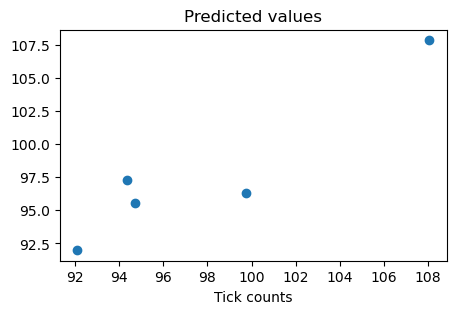

In [47]:
model = LinearRegression()
model.fit(Cumu_index_norm, T_cts)
predictions = model.predict(Cumu_index_norm)
RMSE = np.sqrt(sum((predictions - T_cts) * (predictions - T_cts)) / n_period)
print (f'RMSE = {RMSE}')

fig, ax = plt.subplots(figsize = (5,3))
plt.scatter(T_cts, predictions)
plt.xlabel('Tick counts')
ax.set_title('Predicted values')

<font color = 'Blue'> <b>Test of normal distribution</b>
<br>
</font>
Q-Q plot

Text(0, 0.5, 'Tick counts')

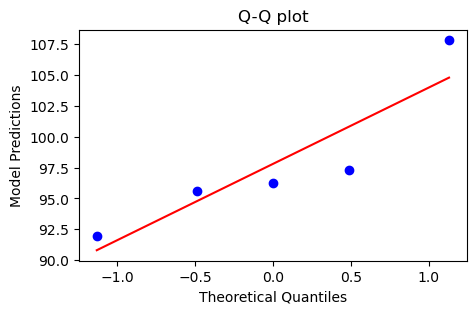

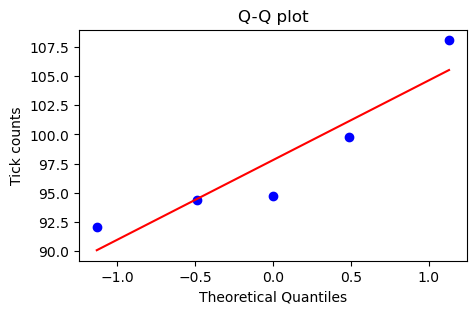

In [45]:
fig, ax = plt.subplots(figsize = (5,3))
stats.probplot(predictions, dist = 'norm', plot = plt)
plt.title('Q-Q plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Model Predictions')

fig1, ax1 = plt.subplots(figsize = (5,3))
stats.probplot(T_cts, dist = 'norm', plot = plt)
plt.title('Q-Q plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Tick counts')

<font color = 'Blue'> <b>T test</b>
<br>
</font>

<b>Independent Sample T-test <br></b>
Null Hypothesis (H0): no sigificant difference between the mean <br>
P-value < 0.05, reject the H0 <br>
(More like comparing distribution)

In [55]:
t_statistic, p_value = stats.ttest_ind(predictions, T_cts)

print(f'T-Statistic: {t_statistic}')
print(f'P-Value: {p_value}')

T-Statistic: 0.0
P-Value: 1.0


<b>Paired Sample T-test <br></b>
Null Hypothesis (H0): no sigificant difference between the mean <br>
P-value < 0.05, reject the H0 <br>
(Compare A1 - B1, A2 - B2, ..., An - Bn)

In [66]:
t_statistic, p_value = stats.ttest_rel(predictions, T_cts)

print(f'T-Statistic: {t_statistic}')
print(f'P-Value: {p_value}')

T-Statistic: 5.486968061829853e-15
P-Value: 0.9999999999999959


T-Statistic: 0.0
P-Value: 1.0


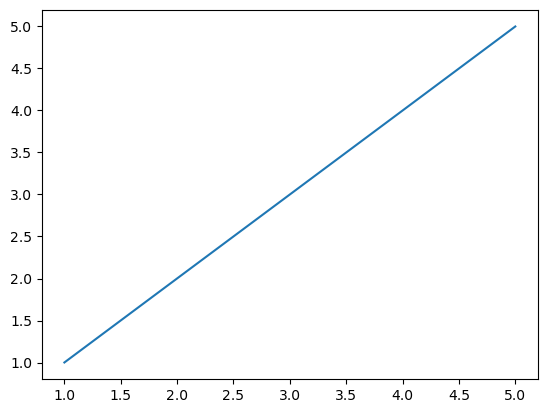

In [65]:
a = np.array([1,2,3,4,5])
b = np.array([1+0.001 , 2+0.001 , 3 , 4-0.001 , 5-0.001])
t_statistic, p_value = stats.ttest_ind(a, b)

print(f'T-Statistic: {t_statistic}')
print(f'P-Value: {p_value}')
plt.plot(a,b)

In [67]:
RedV2.head()

,GMT Time,Latitude,Longitude,Altitude,Duration,Temperatur,Voltage,DOP,Satellites,Cause of F,Lab_Coord,Lab_Dur,Lab_Sat,Lab_Alt,No,time,distance,speed,geometry,LULC
0,8/10/2021 14:31,34.790283,-108.305657,2690.83,65,19.0,0,3.0,5,GPS Schedule,0.0,0.0,0.0,0.0,1,2021-08-10 08:31:00,-1.000000,-1.000000,POINT (746520.733 3853095.300),11
1,8/10/2021 14:45,34.795679,-108.303513,2690.13,3,18.0,0,3.6,5,GPS Schedule,0.0,0.0,0.0,0.0,2,2021-08-10 08:45:00,45.880294,3.276863,POINT (746700.929 3853699.248),2
2,8/10/2021 15:00,34.792382,-108.297636,2685.92,3,18.5,0,3.8,5,GPS Schedule,0.0,0.0,0.0,0.0,3,2021-08-10 09:00:00,85.194239,2.353872,POINT (747248.551 3853347.996),11
3,8/10/2021 15:15,34.794316,-108.304693,2677.39,3,18.5,0,3.2,5,GPS Schedule,0.0,0.0,0.0,0.0,4,2021-08-10 09:15:00,8.960635,0.463648,POINT (746596.977 3853545.118),11
4,8/10/2021 15:30,34.799378,-108.307767,2651.16,2,18.5,0,2.6,5,GPS Schedule,0.0,0.0,0.0,0.0,5,2021-08-10 09:30:00,9.585296,0.702347,POINT (746300.609 3854099.176),11


In [71]:
RedV2 = RedV2.sort_values(by = 'No')
RedV2

,GMT Time,Latitude,Longitude,Altitude,Duration,Temperatur,Voltage,DOP,Satellites,Cause of F,Lab_Coord,Lab_Dur,Lab_Sat,Lab_Alt,No,time,distance,speed,geometry,LULC
0,8/10/2021 14:31,34.790283,-108.305657,2690.83,65,19.0,0,3.0,5,GPS Schedule,0.0,0.0,0.0,0.0,1,2021-08-10 08:31:00,-1.000000,-1.000000,POINT (746520.733 3853095.300),11
1,8/10/2021 14:45,34.795679,-108.303513,2690.13,3,18.0,0,3.6,5,GPS Schedule,0.0,0.0,0.0,0.0,2,2021-08-10 08:45:00,45.880294,3.276863,POINT (746700.929 3853699.248),2
2,8/10/2021 15:00,34.792382,-108.297636,2685.92,3,18.5,0,3.8,5,GPS Schedule,0.0,0.0,0.0,0.0,3,2021-08-10 09:00:00,85.194239,2.353872,POINT (747248.551 3853347.996),11
3,8/10/2021 15:15,34.794316,-108.304693,2677.39,3,18.5,0,3.2,5,GPS Schedule,0.0,0.0,0.0,0.0,4,2021-08-10 09:15:00,8.960635,0.463648,POINT (746596.977 3853545.118),11
4,8/10/2021 15:30,34.799378,-108.307767,2651.16,2,18.5,0,2.6,5,GPS Schedule,0.0,0.0,0.0,0.0,5,2021-08-10 09:30:00,9.585296,0.702347,POINT (746300.609 3854099.176),11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2712,10/8/2021 14:30,34.938247,-108.277773,1779.44,2,14.5,0,1.0,6,GPS Schedule,0.0,0.0,0.0,0.0,3540,2021-10-08 08:30:00,10.557870,0.495932,POINT (748626.601 3869579.002),11
2713,10/8/2021 14:45,34.939316,-108.276832,1792.66,3,15.5,0,1.0,8,GPS Schedule,0.0,0.0,0.0,0.0,3541,2021-10-08 08:45:00,9.279421,14.271261,POINT (748709.310 3869699.891),11
2714,10/8/2021 15:00,34.942255,-108.278813,1786.06,1,16.0,0,1.0,8,GPS Schedule,0.0,0.0,0.0,0.0,3542,2021-10-08 09:00:00,561.571028,7.467805,POINT (748519.479 3870021.045),11
2715,10/8/2021 15:46,34.828757,-108.307587,2456.15,64,14.0,0,1.2,7,GPS Schedule,0.0,0.0,0.0,0.0,3545,2021-10-08 09:46:00,35.853340,0.494999,POINT (746229.565 3857358.763),11
